## Imports

----


In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import train_test_split,cross_val_score
from sklearn.ensemble import RandomForestClassifier,GradientBoostingClassifier
from sklearn.dummy import DummyClassifier
from sklearn.metrics import ConfusionMatrixDisplay,precision_score,accuracy_score,recall_score,RocCurveDisplay
from imblearn.under_sampling import NearMiss 
import pickle
from flask import Flask, request, jsonify
import os

## Exploração de dados

In [2]:
data= pd.read_csv('..\DADOS\DADOSJUNTOS.csv')
data

,pessoa_id,idade,salario_anual,situacao_moradia,tempo_de_trabalho,motivo_do_emprestimo,pontuacao,valor_emprestimo,taxa_de_juros,possibilidade_de_inadimplencia,renda_percentual,inadimplente,tempo_solicitacao
0,1ZbMkM4F-9u8Y,32.0,77400.0,Mortgage,0.0,Debtconsolidation,F,10000.0,18.43,1.0,0.13,N,6
1,2Mbkmbsu-7foj,NaN,30000.0,Rent,1.0,Personal,A,7200.0,17.58,NaN,0.14,Y,2
2,283zsKkk-MN9S,23.0,108000.0,Mortgage,5.0,Debtconsolidation,D,10000.0,NaN,1.0,0.09,Y,2
3,2KDiPOQQ-H7G5,32.0,80000.0,Rent,0.0,Debtconsolidation,C,5000.0,NaN,0.0,0.06,N,6
4,0PtiPv5h-nd0L,21.0,47580.0,Mortgage,5.0,Education,A,14000.0,6.03,0.0,0.29,N,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...
34480,u2bFPCXN-KETS,29.0,91200.0,Mortgage,13.0,Personal,B,2000.0,11.49,0.0,0.02,N,8
34481,TzkLiOab-Iksj,23.0,65000.0,Mortgage,3.0,Medical,A,7000.0,7.90,0.0,0.11,N,4
34482,zHG1040U-BAsd,26.0,54996.0,Rent,8.0,Education,B,20000.0,12.18,1.0,0.36,N,4
34483,mTc8nwE0-fkep,24.0,28590.0,Rent,7.0,Debtconsolidation,D,8000.0,15.65,1.0,0.28,Y,2


In [3]:
data.shape

(34485, 13)

In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 34485 entries, 0 to 34484
Data columns (total 13 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   pessoa_id                       34485 non-null  object 
 1   idade                           34165 non-null  float64
 2   salario_anual                   34150 non-null  float64
 3   situacao_moradia                34154 non-null  object 
 4   tempo_de_trabalho               33231 non-null  float64
 5   motivo_do_emprestimo            34174 non-null  object 
 6   pontuacao                       34176 non-null  object 
 7   valor_emprestimo                34154 non-null  float64
 8   taxa_de_juros                   30859 non-null  float64
 9   possibilidade_de_inadimplencia  34142 non-null  float64
 10  renda_percentual                34170 non-null  float64
 11  inadimplente                    34119 non-null  object 
 12  tempo_solicitacao               

Há muitos dados nulos, e a melhor opção seria preenchê-los

In [5]:
data.columns


Index(['pessoa_id', 'idade', 'salario_anual', 'situacao_moradia',
       'tempo_de_trabalho', 'motivo_do_emprestimo', 'pontuacao',
       'valor_emprestimo', 'taxa_de_juros', 'possibilidade_de_inadimplencia',
       'renda_percentual', 'inadimplente', 'tempo_solicitacao'],
      dtype='object')

# Tratamento de dados **nulos** ou em **branco**

In [6]:
lista = ['idade', 'salario_anual','tempo_de_trabalho', 'taxa_de_juros',
         'possibilidade_de_inadimplencia','valor_emprestimo','tempo_solicitacao', 'renda_percentual']

for i in lista:
    data[i].fillna(data[i].median(), inplace=True)


In [7]:
lista = ['motivo_do_emprestimo', 'pontuacao']

for i in lista:
    data[i].fillna('', inplace=True)


In [8]:
data['situacao_moradia'].fillna('', inplace = True)
index = data.query("situacao_moradia == ''").index
data.drop(index = index, inplace = True)

In [9]:
map={'N': 0, 'Y':1}
data.inadimplente= data.inadimplente.map(map)

In [10]:
data.head()

,pessoa_id,idade,salario_anual,situacao_moradia,tempo_de_trabalho,motivo_do_emprestimo,pontuacao,valor_emprestimo,taxa_de_juros,possibilidade_de_inadimplencia,renda_percentual,inadimplente,tempo_solicitacao
0,1ZbMkM4F-9u8Y,32.0,77400.0,Mortgage,0.0,Debtconsolidation,F,10000.0,18.43,1.0,0.13,0.0,6
1,2Mbkmbsu-7foj,26.0,30000.0,Rent,1.0,Personal,A,7200.0,17.58,0.0,0.14,1.0,2
2,283zsKkk-MN9S,23.0,108000.0,Mortgage,5.0,Debtconsolidation,D,10000.0,10.99,1.0,0.09,1.0,2
3,2KDiPOQQ-H7G5,32.0,80000.0,Rent,0.0,Debtconsolidation,C,5000.0,10.99,0.0,0.06,0.0,6
4,0PtiPv5h-nd0L,21.0,47580.0,Mortgage,5.0,Education,A,14000.0,6.03,0.0,0.29,0.0,2


# Remoção de dados nulos

In [11]:
data.drop(['pessoa_id'],inplace=True,axis=1)

In [12]:
data.isnull().sum()


idade                               0
salario_anual                       0
situacao_moradia                    0
tempo_de_trabalho                   0
motivo_do_emprestimo                0
pontuacao                           0
valor_emprestimo                    0
taxa_de_juros                       0
possibilidade_de_inadimplencia      0
renda_percentual                    0
inadimplente                      334
tempo_solicitacao                   0
dtype: int64

In [13]:
data.dropna(inplace = True)

In [14]:
data.head()

,idade,salario_anual,situacao_moradia,tempo_de_trabalho,motivo_do_emprestimo,pontuacao,valor_emprestimo,taxa_de_juros,possibilidade_de_inadimplencia,renda_percentual,inadimplente,tempo_solicitacao
0,32.0,77400.0,Mortgage,0.0,Debtconsolidation,F,10000.0,18.43,1.0,0.13,0.0,6
1,26.0,30000.0,Rent,1.0,Personal,A,7200.0,17.58,0.0,0.14,1.0,2
2,23.0,108000.0,Mortgage,5.0,Debtconsolidation,D,10000.0,10.99,1.0,0.09,1.0,2
3,32.0,80000.0,Rent,0.0,Debtconsolidation,C,5000.0,10.99,0.0,0.06,0.0,6
4,21.0,47580.0,Mortgage,5.0,Education,A,14000.0,6.03,0.0,0.29,0.0,2


# Remoção dos outliers

### A variável **inadimplente** é a unica que possui nulos,porém por hora é melhor deixa-la de lado

 as variáveis salario_anual,idade e tempo_de_trabalho são aquelas que mais possuem outiliers relevantes no dataframe

Text(0.5, 1.0, 'Box plot com dados com outiliers')

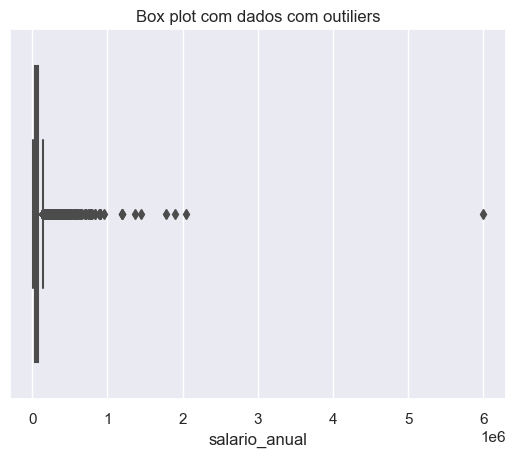

In [15]:
sns.set_theme(style="darkgrid")
sns.boxplot(x=data.salario_anual)
plt.title('Box plot com dados com outiliers')

Text(0.5, 1.0, 'Box plot com dados com outiliers')

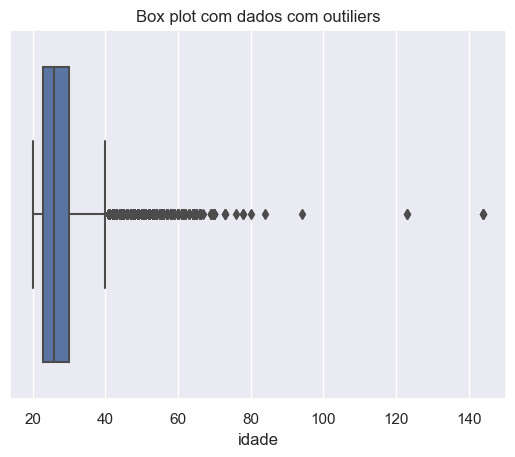

In [16]:
sns.boxplot(x=data.idade)
plt.title('Box plot com dados com outiliers')

Text(0.5, 1.0, 'Box plot com dados com outiliers')

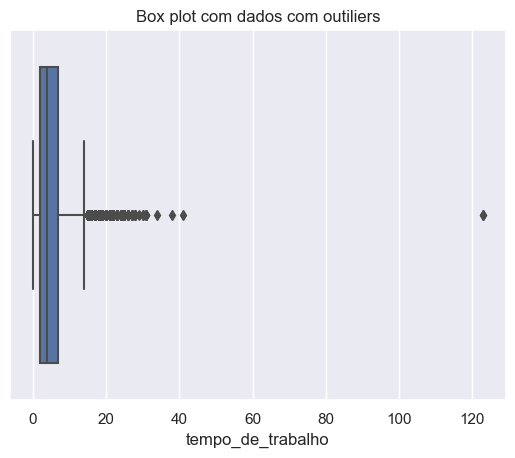

In [17]:
sns.boxplot(x=data.tempo_de_trabalho)
plt.title('Box plot com dados com outiliers')

In [18]:
data.reset_index(drop=True,inplace=True)

In [19]:
lista1=list(data.query("idade>=100").index)

In [20]:
lista2=list(data.query("tempo_de_trabalho>=100").index)


In [21]:
lista3=list(data.query("salario_anual>=800000").index)

In [22]:
for i in [lista1,lista2,lista3]:
  data.drop(i,inplace=True,errors='ignore')

In [23]:
data.reset_index(drop=True,inplace=True)

<Figure size 1000x1200 with 0 Axes>

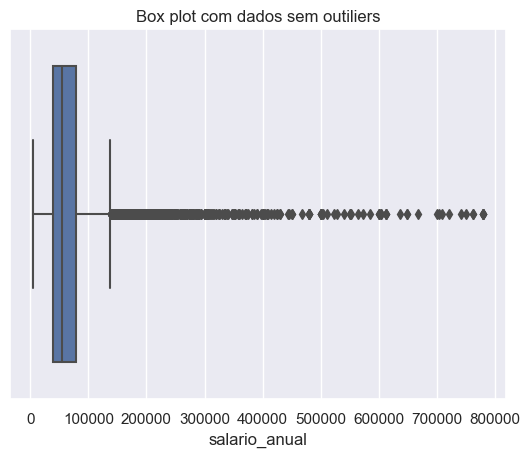

<Figure size 1000x1200 with 0 Axes>

In [24]:
sns.boxplot(x=data.salario_anual)
plt.title('Box plot com dados sem outiliers')
plt.figure(figsize=(10,12))

Text(0.5, 1.0, 'Box plot com dados sem outiliers')

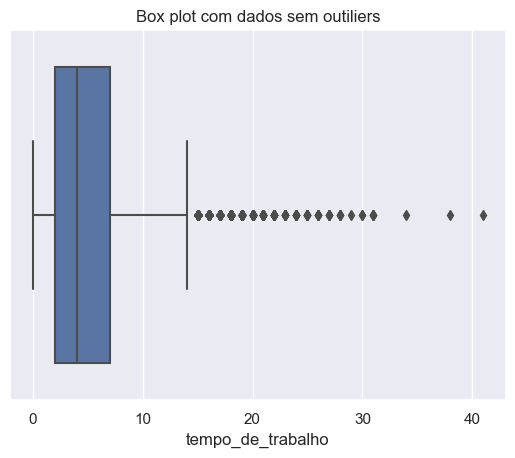

In [25]:
sns.boxplot(x=data.tempo_de_trabalho)
plt.title('Box plot com dados sem outiliers')

Text(0.5, 1.0, 'Box plot com dados sem outiliers')

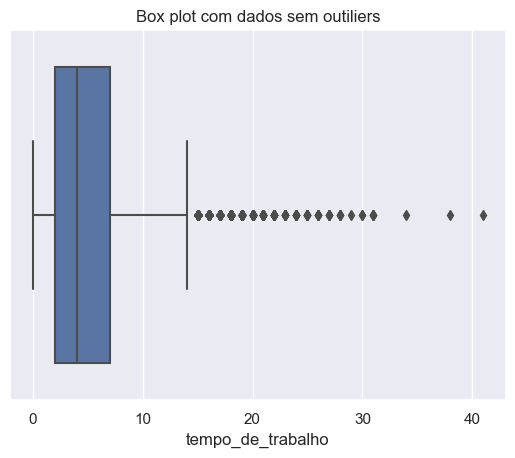

In [26]:
sns.boxplot(x=data.tempo_de_trabalho)
plt.title('Box plot com dados sem outiliers')

Correlação e normalização dos dados

In [27]:
data.corr()

,idade,salario_anual,tempo_de_trabalho,valor_emprestimo,taxa_de_juros,possibilidade_de_inadimplencia,renda_percentual,inadimplente,tempo_solicitacao
idade,1.000000,0.129043,0.167879,0.048057,0.011381,-0.019650,-0.039151,0.007735,0.846379
salario_anual,0.129043,1.000000,0.169095,0.356679,0.000045,-0.182164,-0.314834,-0.003303,0.105451
tempo_de_trabalho,0.167879,0.169095,1.000000,0.107297,-0.050887,-0.083567,-0.056685,-0.027550,0.141886
valor_emprestimo,0.048057,0.356679,0.107297,1.000000,0.139956,0.104002,0.569383,0.039936,0.042889
taxa_de_juros,0.011381,0.000045,-0.050887,0.139956,1.000000,0.316794,0.114335,0.475324,0.015050
possibilidade_de_inadimplencia,-0.019650,-0.182164,-0.083567,0.104002,0.316794,1.000000,0.375227,0.177236,-0.014981
renda_percentual,-0.039151,-0.314834,-0.056685,0.569383,0.114335,0.375227,1.000000,0.035477,-0.029821
inadimplente,0.007735,-0.003303,-0.027550,0.039936,0.475324,0.177236,0.035477,1.000000,0.005031
tempo_solicitacao,0.846379,0.105451,0.141886,0.042889,0.015050,-0.014981,-0.029821,0.005031,1.000000


Plot em heatmap

<Figure size 1500x1500 with 0 Axes>

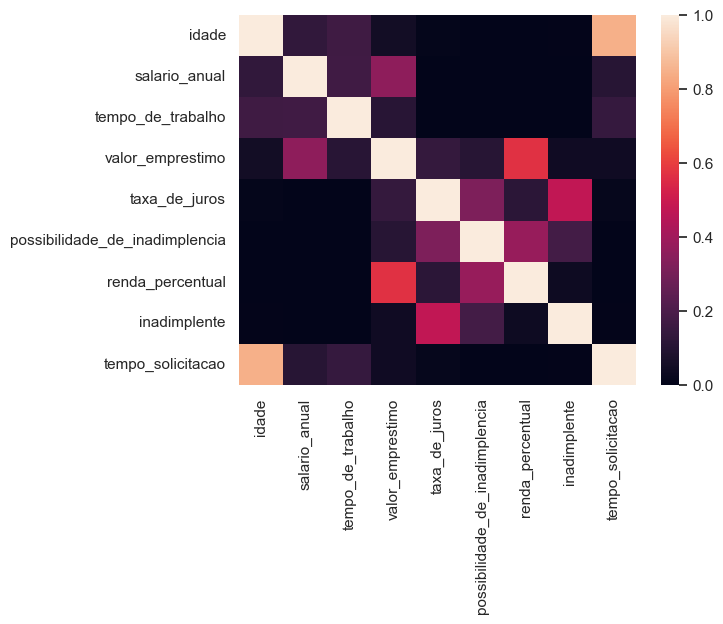

<Figure size 1500x1500 with 0 Axes>

In [28]:
sns.heatmap(data.corr(), vmin=0, vmax=1)
plt.figure(figsize=(15,15))

In [29]:
data.isnull().sum()
data.dropna(inplace = True)

In [30]:
y = data[['inadimplente']]
y.shape

(33795, 1)

In [31]:
X=data.drop(['inadimplente'],axis=1)
X.shape
X[['situacao_moradia',]]

,situacao_moradia
0,Mortgage
1,Rent
2,Mortgage
3,Rent
4,Mortgage
...,...
33790,Mortgage
33791,Mortgage
33792,Rent
33793,Rent


# Mapeamento dos dados,tranformando-os em variáveis quantitativas

In [32]:
one_hot_enc=OneHotEncoder(handle_unknown='ignore',sparse=False)

x = pd.DataFrame(one_hot_enc.fit_transform(X[['situacao_moradia','motivo_do_emprestimo','pontuacao']]).toarray())
X= X.join(x)


In [33]:
X.drop(['situacao_moradia','motivo_do_emprestimo','pontuacao'],inplace=True, axis =1)


In [35]:
X

,idade,salario_anual,tempo_de_trabalho,valor_emprestimo,taxa_de_juros,possibilidade_de_inadimplencia,renda_percentual,tempo_solicitacao,0,1,...,9,10,11,12,13,14,15,16,17,18
0,32.0,77400.0,0.0,10000.0,18.43,1.0,0.13,6,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1,26.0,30000.0,1.0,7200.0,17.58,0.0,0.14,2,0.0,0.0,...,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
2,23.0,108000.0,5.0,10000.0,10.99,1.0,0.09,2,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
3,32.0,80000.0,0.0,5000.0,10.99,0.0,0.06,6,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
4,21.0,47580.0,5.0,14000.0,6.03,0.0,0.29,2,1.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
33790,29.0,91200.0,13.0,2000.0,11.49,0.0,0.02,8,1.0,0.0,...,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
33791,23.0,65000.0,3.0,7000.0,7.90,0.0,0.11,4,1.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
33792,26.0,54996.0,8.0,20000.0,12.18,1.0,0.36,4,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
33793,24.0,28590.0,7.0,8000.0,15.65,1.0,0.28,2,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0


In [36]:
X.columns

Index([                         'idade',                  'salario_anual',
                    'tempo_de_trabalho',               'valor_emprestimo',
                        'taxa_de_juros', 'possibilidade_de_inadimplencia',
                     'renda_percentual',              'tempo_solicitacao',
                                      0,                                1,
                                      2,                                3,
                                      4,                                5,
                                      6,                                7,
                                      8,                                9,
                                     10,                               11,
                                     12,                               13,
                                     14,                               15,
                                     16,                               17,
                         

In [37]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 33795 entries, 0 to 33794
Data columns (total 27 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   idade                           33795 non-null  float64
 1   salario_anual                   33795 non-null  float64
 2   tempo_de_trabalho               33795 non-null  float64
 3   valor_emprestimo                33795 non-null  float64
 4   taxa_de_juros                   33795 non-null  float64
 5   possibilidade_de_inadimplencia  33795 non-null  float64
 6   renda_percentual                33795 non-null  float64
 7   tempo_solicitacao               33795 non-null  int64  
 8   0                               33795 non-null  float64
 9   1                               33795 non-null  float64
 10  2                               33795 non-null  float64
 11  3                               33795 non-null  float64
 12  4                               

# Balanceando os dados

<Figure size 1000x1500 with 0 Axes>

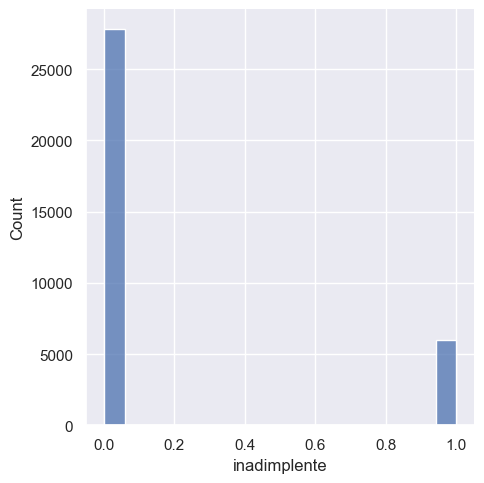

<Figure size 1000x1500 with 0 Axes>

In [38]:
sns.displot(x=y.inadimplente,legend=True)
plt.figure(figsize=(10,15))

In [39]:
nm = NearMiss()
X_res, y_res = nm.fit_resample(X, y)

C:\Users\hever\AppData\Roaming\Python\Python39\site-packages\sklearn\utils\validation.py:1858: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(


<Figure size 1000x1500 with 0 Axes>

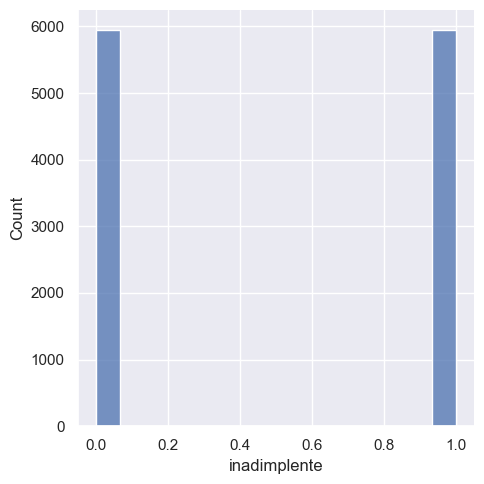

<Figure size 1000x1500 with 0 Axes>

In [40]:
sns.displot(x=y_res.inadimplente)
plt.figure(figsize=(10,15))

In [41]:
X_res.values

array([[2.300e+01, 5.400e+04, 1.000e+00, ..., 0.000e+00, 0.000e+00,
        0.000e+00],
       [2.300e+01, 3.000e+04, 1.000e+00, ..., 1.000e+00, 0.000e+00,
        0.000e+00],
       [2.300e+01, 4.000e+04, 4.000e+00, ..., 0.000e+00, 0.000e+00,
        0.000e+00],
       ...,
       [3.600e+01, 8.400e+04, 6.000e+00, ..., 0.000e+00, 0.000e+00,
        0.000e+00],
       [2.400e+01, 2.736e+04, 4.000e+00, ..., 0.000e+00, 0.000e+00,
        0.000e+00],
       [2.400e+01, 2.859e+04, 7.000e+00, ..., 0.000e+00, 0.000e+00,
        0.000e+00]])

In [42]:
# normalizando
norm=StandardScaler()
X_novo=norm.fit_transform(X_res)
X_novo.shape

C:\Users\hever\AppData\Roaming\Python\Python39\site-packages\sklearn\utils\validation.py:1858: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\hever\AppData\Roaming\Python\Python39\site-packages\sklearn\utils\validation.py:1858: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(


(11898, 27)

In [43]:
X_treino,X_teste,Y_treino,Y_teste=train_test_split(X_novo,y_res,test_size=0.25,stratify=y_res,random_state=42 )

In [44]:
x_treino= X_treino.reshape(-1, 1)
x_teste = X_teste.reshape(-1, 1)
Y_treino.value_counts()

inadimplente
1.0             4462
0.0             4461
dtype: int64

In [45]:
print(f'X completo tem {X_novo.shape}, e o de treino tem {X_treino.shape} já o de teste tem {X_teste.shape}')

X completo tem (11898, 27), e o de treino tem (8923, 27) já o de teste tem (2975, 27)


# Modelo

In [46]:
tree= RandomForestClassifier(max_depth=10,random_state=42,criterion='entropy',min_samples_split=2,\
                             min_samples_leaf=2)
tree=tree.fit(X_treino,np.ravel(Y_treino))
Y_pred=tree.predict(X_teste)


In [47]:
Y_pred

array([1., 1., 0., ..., 0., 0., 0.])

In [48]:
print(accuracy_score(Y_teste,Y_pred),
precision_score(Y_teste,Y_pred),recall_score(Y_teste,Y_pred))
print(cross_val_score(tree,X_treino,np.ravel(Y_treino)))

0.8998319327731092 0.8387464387464387 0.9899125756556826
[0.87170868 0.88515406 0.88571429 0.8867713  0.89686099]


In [49]:
dm= DummyClassifier(strategy="most_frequent")
dm=dm.fit(X_treino,np.ravel(Y_treino))
Y_pred_dm=dm.predict(X_teste)
print(accuracy_score(Y_teste,Y_pred_dm),precision_score(Y_teste,Y_pred_dm),recall_score(Y_teste,Y_pred_dm))
print(cross_val_score(dm,X_treino,np.ravel(Y_treino)))

0.4998319327731092 0.4998319327731092 1.0
[0.49971989 0.49971989 0.49971989 0.5        0.5       ]


# Matriz de Confusão & Curva ROC 

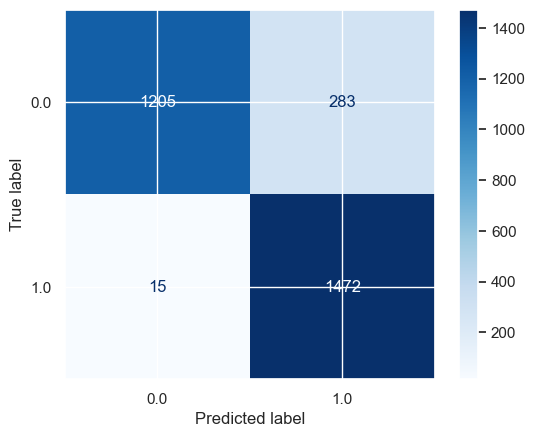

In [50]:
ConfusionMatrixDisplay.from_estimator(tree, X_teste, Y_teste,cmap='Blues')

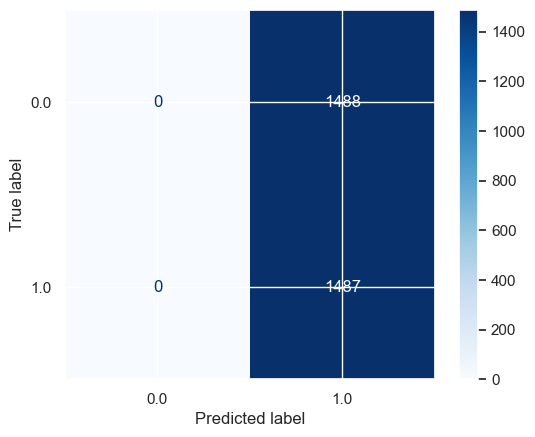

In [51]:
ConfusionMatrixDisplay.from_estimator(dm, X_teste, Y_teste,cmap='Blues')

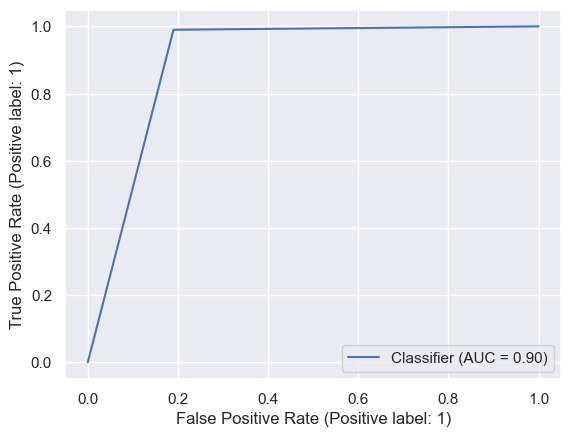

In [52]:
RocCurveDisplay.from_predictions(Y_teste, Y_pred)

# Exportação 

In [53]:
filename = 'modelo_tree.pkl'
pickle.dump(tree, open(filename, 'wb'))
filename= 'OneHotEncoder.pkl'
pickle.dump(one_hot_enc, open(filename, 'wb'))
filename= 'norm.pkl'
pickle.dump(norm, open(filename, 'wb'))